# Processamento dos dados e análise de sentimento.
Bibliotecas necessárias

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import os 
import xml.etree.ElementTree as ET
import requests
from transformers import AutoTokenizer, BertForSequenceClassification
import torch
import PyPDF2

In [15]:
# Dados históricos da empresa
df = pd.read_csv("../dataset/prices_data/BBAS3.SA.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,14.900000,15.000000,14.850000,14.950000,6.009221,7249400
2010-01-05,15.050000,15.050000,14.595000,14.800000,5.948927,6129800
2010-01-06,14.745000,15.000000,14.710000,14.820000,5.956966,5466200
2010-01-07,14.720000,14.855000,14.705000,14.825000,5.958977,3084400
2010-01-08,14.850000,14.910000,14.735000,14.910000,5.993145,4077800
...,...,...,...,...,...,...
2024-05-27,27.139999,27.469999,27.080000,27.410000,27.410000,31296700
2024-05-28,27.549999,27.620001,27.290001,27.320000,27.320000,35304600
2024-05-29,27.469999,27.469999,27.120001,27.320000,27.320000,25627500


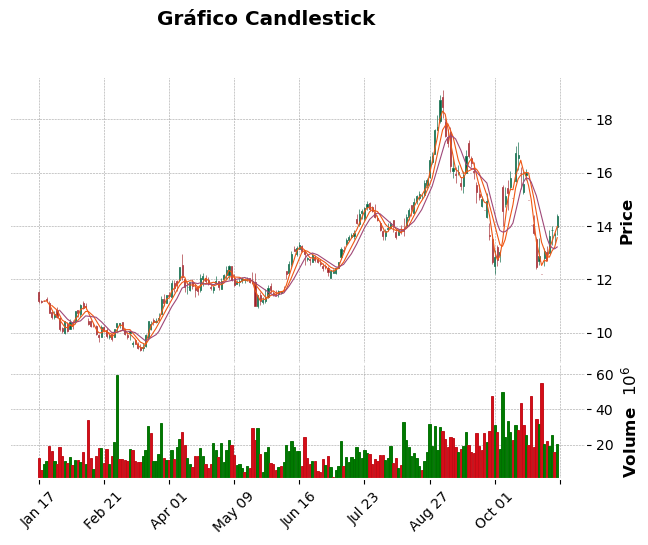

In [16]:
mpf.plot(df.iloc[1000:1200], type='candle', style='charles', volume=True, title='Gráfico Candlestick', mav=(3, 6, 9))

In [17]:
# Criando ferramenta para adicionar novos campos para o dataframe
def catalog_return(row, x, name_return):
    if row[name_return] > x * row[f'Cumulative_std_{name_return}']:
        return 1
    elif row[name_return] < -x * row[f'Cumulative_std_{name_return}']:
        return -1
    else:
        return 0


class DataProcessing:
    def __init__(self, data):
        self.dataframe = data
        self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
        self.dataframe = self.dataframe.sort_values(by='Date')

    def get_by_date_range(self, start_date, end_date):
        mask = ((self.dataframe['Date'] >= start_date) & (self.dataframe['Date'] <= end_date))
        return self.dataframe.loc[mask]

    def get_by_date(self, date):
        return self.dataframe.loc[(self.dataframe['Date'] == date)]

    def create_return_by_period(self, name_return, period, remove_nan=False):
        self.dataframe[f'{name_return}'] = np.log(
            self.dataframe['Close'] / self.dataframe['Close'].shift(period))
        if remove_nan:
            self.dataframe = self.dataframe.dropna()

    def create_cumulative_std(self, name_return):
        self.dataframe[f'Cumulative_std_{name_return}'] = self.dataframe[name_return].expanding().std()

    def create_indicator(self, name_return, factor):
        self.dataframe[f'Indicator_{name_return}'] = self.dataframe.apply(lambda row:
                                                                          catalog_return(row, factor, name_return),
                                                                          axis=1)


In [18]:
# Criando os novos campos em todos os dataframes
files = os.listdir('../dataset/prices_data')
for file in files:
    data_processed = DataProcessing(pd.read_csv(f'../dataset/prices_data/{file}'))
    data_processed.create_return_by_period(name_return='Daily_Return', period=1, remove_nan=False)
    data_processed.create_return_by_period(name_return='Week_Return', period=6, remove_nan=False)
    data_processed.create_return_by_period(name_return='Month_Return', period=22, remove_nan=False)
    data_processed.create_cumulative_std(name_return='Daily_Return')
    data_processed.create_cumulative_std(name_return='Week_Return')
    data_processed.create_cumulative_std(name_return='Month_Return')
    data_processed.create_indicator(name_return='Daily_Return', factor=0.1)
    data_processed.create_indicator(name_return='Week_Return', factor=0.1)
    data_processed.create_indicator(name_return='Month_Return', factor=0.1)
    data_processed.dataframe.to_csv(f'../dataset/prices_processed/{file}', index_label=False)
    print(f'File {file} created and save in ../dataset/prices_processed/{file}')

File ANIM3.SA.csv created and save in ../dataset/prices_processed/ANIM3.SA.csv
File AZUL4.SA.csv created and save in ../dataset/prices_processed/AZUL4.SA.csv
File BBAS3.SA.csv created and save in ../dataset/prices_processed/BBAS3.SA.csv
File BBDC4.SA.csv created and save in ../dataset/prices_processed/BBDC4.SA.csv
File BHIA3.SA.csv created and save in ../dataset/prices_processed/BHIA3.SA.csv
File BRFS3.SA.csv created and save in ../dataset/prices_processed/BRFS3.SA.csv
File CCRO3.SA.csv created and save in ../dataset/prices_processed/CCRO3.SA.csv
File CPFE3.SA.csv created and save in ../dataset/prices_processed/CPFE3.SA.csv
File CSAN3.SA.csv created and save in ../dataset/prices_processed/CSAN3.SA.csv
File DASA3.SA.csv created and save in ../dataset/prices_processed/DASA3.SA.csv
File FLRY3.SA.csv created and save in ../dataset/prices_processed/FLRY3.SA.csv
File GOLL4.SA.csv created and save in ../dataset/prices_processed/GOLL4.SA.csv
File HAPV3.SA.csv created and save in ../dataset/pri

In [19]:
df_processed = pd.read_csv(f'../dataset/prices_processed/BBAS3.SA.csv')
df_processed['Date'] = pd.to_datetime(df_processed['Date'])
df_processed

,Date,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Week_Return,Month_Return,Cumulative_std_Daily_Return,Cumulative_std_Week_Return,Cumulative_std_Month_Return,Indicator_Daily_Return,Indicator_Week_Return,Indicator_Month_Return
0,2010-01-04,14.900000,15.000000,14.850000,14.950000,6.009221,7249400,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,2010-01-05,15.050000,15.050000,14.595000,14.800000,5.948927,6129800,-0.010084,NaN,NaN,NaN,NaN,NaN,0,0,0
2,2010-01-06,14.745000,15.000000,14.710000,14.820000,5.956966,5466200,0.001350,NaN,NaN,0.008085,NaN,NaN,1,0,0
3,2010-01-07,14.720000,14.855000,14.705000,14.825000,5.958977,3084400,0.000337,NaN,NaN,0.006330,NaN,NaN,0,0,0
4,2010-01-08,14.850000,14.910000,14.735000,14.910000,5.993145,4077800,0.005717,NaN,NaN,0.006696,NaN,NaN,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3573,2024-05-27,27.139999,27.469999,27.080000,27.410000,27.410000,31296700,0.012112,-0.010163,-0.003278,0.024863,0.060810,0.116363,1,-1,0
3574,2024-05-28,27.549999,27.620001,27.290001,27.320000,27.320000,35304600,-0.003289,-0.021724,-0.002194,0.024859,0.060803,0.116347,-1,-1,0
3575,2024-05-29,27.469999,27.469999,27.120001,27.320000,27.320000,25627500,0.000000,-0.021008,-0.002194,0.024856,0.060796,0.116330,0,-1,0
3576,2024-05-31,27.379999,27.500000,27.120001,27.120001,27.120001,19114900,-0.007348,-0.013915,-0.015731,0.024853,0.060788,0.116314,-1,-1,-1


In [20]:
# Coleta das datas das reuniões trimestrais
date_df = pd.read_csv('../dataset/transcripts/BB/datas.csv')
date_df['data'] = pd.to_datetime(date_df['data'])
date_df = date_df.sort_values(by=['data'], ignore_index=True)
date_df['prox_evento'] = date_df['trimestre'].shift(periods=-1)
date_df

,trimestre,data,prox_evento
0,1T2010,2010-05-14,2T2010
1,2T2010,2010-08-17,3T2010
2,3T2010,2010-11-17,4T2010
3,4T2010,2011-02-18,1T2011
4,1T2011,2011-05-11,2T2011
5,2T2011,2011-08-10,3T2011
6,3T2011,2011-11-04,4T2011
7,4T2011,2012-02-15,1T2012
8,1T2012,2012-05-04,2T2012
9,2T2012,2012-08-15,3T2012


In [21]:
# Inserindo a informação se teve evento no dia X
df_processed.insert(1, 'event', df_processed['Date'].apply(lambda date: 1 if date in date_df['data'].values else 0))
df_processed

,Date,event,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Week_Return,Month_Return,Cumulative_std_Daily_Return,Cumulative_std_Week_Return,Cumulative_std_Month_Return,Indicator_Daily_Return,Indicator_Week_Return,Indicator_Month_Return
0,2010-01-04,0,14.900000,15.000000,14.850000,14.950000,6.009221,7249400,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,2010-01-05,0,15.050000,15.050000,14.595000,14.800000,5.948927,6129800,-0.010084,NaN,NaN,NaN,NaN,NaN,0,0,0
2,2010-01-06,0,14.745000,15.000000,14.710000,14.820000,5.956966,5466200,0.001350,NaN,NaN,0.008085,NaN,NaN,1,0,0
3,2010-01-07,0,14.720000,14.855000,14.705000,14.825000,5.958977,3084400,0.000337,NaN,NaN,0.006330,NaN,NaN,0,0,0
4,2010-01-08,0,14.850000,14.910000,14.735000,14.910000,5.993145,4077800,0.005717,NaN,NaN,0.006696,NaN,NaN,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3573,2024-05-27,0,27.139999,27.469999,27.080000,27.410000,27.410000,31296700,0.012112,-0.010163,-0.003278,0.024863,0.060810,0.116363,1,-1,0
3574,2024-05-28,0,27.549999,27.620001,27.290001,27.320000,27.320000,35304600,-0.003289,-0.021724,-0.002194,0.024859,0.060803,0.116347,-1,-1,0
3575,2024-05-29,0,27.469999,27.469999,27.120001,27.320000,27.320000,25627500,0.000000,-0.021008,-0.002194,0.024856,0.060796,0.116330,0,-1,0
3576,2024-05-31,0,27.379999,27.500000,27.120001,27.120001,27.120001,19114900,-0.007348,-0.013915,-0.015731,0.024853,0.060788,0.116314,-1,-1,-1


Separando os retornos em: após o evento e demais. Para os 3 tipos de retornos.

In [23]:
def separate_returns(final_data):
    # Inicializar colunas se não existirem
    if 'return_daily' not in final_data.columns:
        final_data['return_daily'] = np.nan
    if 'return_week' not in final_data.columns:
        final_data['return_week'] = np.nan
    if 'return_month' not in final_data.columns:
        final_data['return_month'] = np.nan
        
    first_return_daily_list = []
    remaining_return_daily_list = []
    first_return_week_list = []
    remaining_return_week_list = []
    first_return_month_list = []
    remaining_return_month_list = []

    start_idx = 0

    while start_idx < len(final_data):
        # Encontra o evento
        if 1 in final_data[start_idx:]['event'].values:
            event_idx = final_data[start_idx:]['event'].eq(1).idxmax()
        else:
            break
        # Encontrar o próximo evento
        if 1 in final_data[event_idx+1:]['event'].values:
            prox_event_idx = final_data[event_idx+1:]['event'].eq(1).idxmax()
        else:
            prox_event_idx = len(final_data)
            
        # Calcular o primeiro retorno diario logo após o evento
        if event_idx + 1 < len(final_data):
            final_data.loc[event_idx + 1, 'return_daily'] = np.log(final_data.loc[event_idx + 1, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_daily_list.append(final_data.iloc[event_idx + 1])

        # Calcular os retornos diarios restantes até o próximo evento
        for i in range(event_idx + 2, prox_event_idx, 1):
            final_data.loc[i, 'return_daily'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-1, 'Close'])
            remaining_return_daily_list.append(final_data.iloc[i])
                
        # Calcular o primeiro retorno semanal logo após o evento
        if event_idx + 5 < len(final_data):
            final_data.loc[event_idx + 5, 'return_week'] = np.log(final_data.loc[event_idx + 5, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_week_list.append(final_data.iloc[event_idx + 5])

        # Calcular os retornos semanais restantes até o próximo evento
        for i in range(event_idx + 10, prox_event_idx, 5):
            final_data.loc[i, 'return_week'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-5, 'Close'])
            remaining_return_week_list.append(final_data.iloc[i])
        

        # Calcular o primeiro retorno mensal logo após o evento
        if event_idx + 21 < len(final_data):
            final_data.loc[event_idx + 21, 'return_month'] = np.log(final_data.loc[event_idx + 21, 'Close'] / final_data.loc[event_idx, 'Close'])
            first_return_month_list.append(final_data.iloc[event_idx + 21])

        # Calcular os retornos mensais restantes até o próximo evento
        for i in range(event_idx + 42, prox_event_idx, 22):
            final_data.loc[i, 'return_month'] = np.log(final_data.loc[i, 'Close'] / final_data.loc[i-21, 'Close'])
            remaining_return_month_list.append(final_data.iloc[i])

        # Reinicia após o evento
        start_idx = event_idx + 1

    # Criar DataFrames para o primeiro e os demais retornos semanais e mensais
    first_return_daily_df = pd.DataFrame(first_return_daily_list).reset_index()[['index',
 'Close', 'Date'
, 'event', 'return_daily']]
    remaining_return_daily_df = pd.DataFrame(remaining_return_daily_list).reset_index()[['index',
 'Close', 'Date'
, 'event', 'return_daily']]
    first_return_week_df = pd.DataFrame(first_return_week_list).reset_index()[['index',
 'Close', 'Date'
, 'event', 'return_week']]
    remaining_return_week_df = pd.DataFrame(remaining_return_week_list).reset_index()[['index',
 'Close', 'Date'
, 'event', 'return_week']]
    first_return_month_df = pd.DataFrame(first_return_month_list).reset_index()[['index',
 'Close', 'Date'
, 'event', 'return_month']]
    remaining_return_month_df = pd.DataFrame(remaining_return_month_list).reset_index()[['index',
 'Close', 'Date'
, 'event', 'return_month']]
    
    first_return_daily_df.rename(columns={'return_daily': 'return'}, inplace=True)
    remaining_return_daily_df.rename(columns={'return_daily': 'return'}, inplace=True)
    first_return_week_df.rename(columns={'return_week': 'return'}, inplace=True)
    remaining_return_week_df.rename(columns={'return_week': 'return'}, inplace=True)
    first_return_month_df.rename(columns={'return_month': 'return'}, inplace=True)
    remaining_return_month_df.rename(columns={'return_month': 'return'}, inplace=True)
    
    return first_return_daily_df, remaining_return_daily_df, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df


first_return_daily_df, remaining_return_daily_df, first_return_week_df, remaining_return_week_df, first_return_month_df, remaining_return_month_df = separate_returns(df_processed)

# Análise de Sentimento

In [10]:
def extract_text_from_pdf(pdf_path):
    # Abrir o arquivo PDF
    with open(pdf_path, 'rb') as file:
        # Criar um objeto PDF Reader
        reader = PyPDF2.PdfReader(file)

        # Inicializar uma variável para armazenar o texto
        all_text = ""

        # Iterar sobre cada página e extrair o texto
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            all_text += page.extract_text()
    # Remover os caracteres de nova linha
    all_text = all_text.replace('\n', ' ')
    # Segmentar o texto usando "." como separador
    segments = all_text.split('. ')

    # Remover espaços em branco desnecessários e segmentos vazios
    segments = [segment.strip() for segment in segments if segment.strip() and len(segment.strip()) >= 15]

    return segments

In [24]:
name_prices = {
    'azul': 'AZUL4.SA',
    'BB': 'BBAS3.SA',
    'bradesco': 'BBDC4.SA',
    'brf': 'BRFS3.SA',
    'ccr': 'CCRO3.SA',
    'cosan': 'CSAN3.SA',
    'cpfl_energia': 'CPFE3.SA',
    'dasa': 'DASA3.SA',
    'fleury': 'FLRY3.SA',
    'gol': 'GOLL4.SA',
    'hapvida': 'HAPV3.SA',
    'itau': 'ITUB4.SA',
    'locaweb': 'LWSA3.SA',
    'magazine_luiza': 'MGLU3.SA',
    'mrv_engenharia': 'MRVE3.SA',
    'natura': 'NTCO3.SA',
    'petrobras': 'PETR4.SA',
    'santander': 'SANB11.SA',
    'sul_america': 'SULA11.SA',
    'totvs': 'TOTS3.SA',
    'vale': 'VALE3.SA',
    'via_varejo': 'BHIA3.SA'

}

Modelo usado

In [25]:
pred_mapper = {
    0: 1, # Resultado positivo
    1: -1, # Resultado negativo
    2: 0 # Resultado neutro
  }
# Modelo usado - FinBERT lucas leme - Huggingface
tokenizer = AutoTokenizer.from_pretrained("lucas-leme/FinBERT-PT-BR")
finbertptbr = BertForSequenceClassification.from_pretrained("lucas-leme/FinBERT-PT-BR")

In [27]:
files = ['magazine_luiza']  # os.listdir("../../dataset/transcripts")
for file in files:
    try:
        df = pd.read_csv(f"../dataset/transcripts_and_returns/{name_prices[file]}.csv")
        for i, row in df.iterrows():
            if not pd.isna(row['positive_sentiment']):
                print(row['positive_sentiment'])
                continue
            text_extract_name = row['trimestre']
            text = extract_text_from_pdf(f'../dataset/transcripts/{file}/{text_extract_name}.pdf')
            tokens = tokenizer(text, return_tensors="pt",
                                   padding=True, truncation=True, max_length=512)

            finbertptbr_outputs = finbertptbr(**tokens)
            preds = [pred_mapper[np.argmax(pred)] for pred in finbertptbr_outputs.logits.cpu().detach().numpy()]
            posi, neut, nega = preds.count(1), preds.count(0), preds.count(-1)
            df.loc[i, 'positive_sentiment'] = posi
            df.loc[i, 'neutral_sentiment'] = neut
            df.loc[i, 'negative_sentiment'] = nega
            df.to_csv(f"../dataset/transcripts_and_returns/{name_prices[file]}.csv", index=False)
            
            del tokens, finbertptbr_outputs, preds
            torch.cuda.empty_cache()

    except FileNotFoundError as e:
        print(f"Erro de arquivo não encontrado: {e}")
    except Exception as e:
        print(f"Ocorreu um erro: {e}")

83.0
107.0
92.0
105.0
101.0
135.0
104.0
104.0
118.0
95.0
99.0
78.0
61.0
84.0
102.0
109.0
107.0
113.0
108.0
128.0
177.0
174.0
152.0
105.0
160.0
144.0
165.0
116.0
118.0
163.0
216.0
200.0
209.0
244.0
194.0
146.0
129.0
114.0
77.0
121.0
107.0
157.0
231.0
152.0
